In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [ ]:

# Load the data
cheaters = np.load('drive/MyDrive/cheaters.npy')
legit = np.load('drive/MyDrive/legit.npy')

In [ ]:
# Combine data
X = np.vstack((cheaters, legit))
# Extract labels (the fifth feature of the last timestep of each engagement) one label per player-engagement combo
# y = X[:, :, -1, 4].reshape(-1)
y = X[:, :, -1, 4][:,0].reshape(-1)
# Remove labels from features
X = X[:, :, :, :4]
# Reshape the data
n_players, n_engagements, n_timesteps, n_features = X.shape
# X_reshaped = X.reshape(n_players * n_engagements, n_timesteps, n_features)

In [ ]:
X.shape

(12000, 30, 192, 4)

In [ ]:
y.shape

(12000,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Define the model
def create_hierarchical_model(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)

    # Engagement-level LSTM
    engagement_lstm = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(64, return_sequences=True))(input_layer)
    engagement_lstm = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(32))(engagement_lstm)

    # Player-level LSTM
    player_lstm = tf.keras.layers.LSTM(32)(engagement_lstm)

    dense = tf.keras.layers.Dense(16, activation='relu')(player_lstm)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    return tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
model = create_hierarchical_model((30, 192, 4))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights
class_weights = dict(zip(np.unique(y), 1 / (np.bincount(y.astype(int)) / len(y))))

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=30,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 122s 383ms/step - accuracy: 0.6955 - loss: 1.3902 - val_accuracy: 0.1292 - val_loss: 0.7677
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 149s 420ms/step - accuracy: 0.4449 - loss: 1.3838 - val_accuracy: 0.1635 - val_loss: 0.7596
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 128s 364ms/step - accuracy: 0.3876 - loss: 1.3349 - val_accuracy: 0.1911 - val_loss: 0.7399
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 142s 365ms/step - accuracy: 0.3491 - loss: 1.3717 - val_accuracy: 0.4740 - val_loss: 0.6772
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 361ms/step - accuracy: 0.5884 - loss: 1.3505 - val_accuracy: 0.2432 - val_loss: 0.7384
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.4855 - loss: 1.3432 - val_accuracy: 0.2396 - val_loss: 0.7335
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 144s 369ms/step - accuracy: 0.3516 - loss: 1.3570 - val_accuracy: 0.6099 - val_loss: 0.6580
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 140s 360ms/step - accuracy: 0.5072 -

In [ ]:
# Evaluate the TensorFlow model
y_pred_proba = model.predict(X_test)
y_pred_tf = (y_pred_proba > 0.5).astype(int)

print("\nTensorFlow LSTM Model Results:")
print(classification_report(y_test, y_pred_tf))
print(confusion_matrix(y_test, y_pred_tf))


75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step

TensorFlow LSTM Model Results:
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85      2320
         1.0       0.03      0.24      0.06        80

    accuracy                           0.74      2400
   macro avg       0.50      0.50      0.45      2400
weighted avg       0.94      0.74      0.82      2400

[[1755  565]
 [  61   19]]


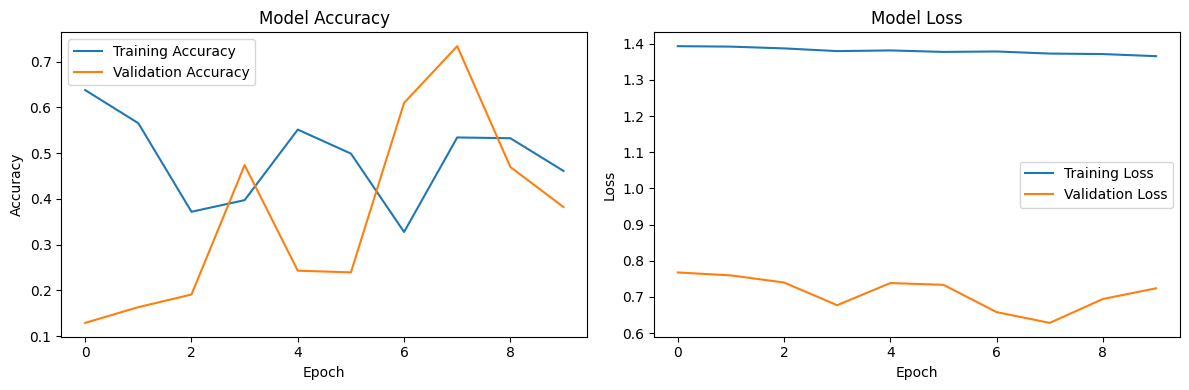

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()